In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import os
import zipfile
from google.colab import files

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Secure the API key

# Download the dataset to the content/ folder
dataset_name = "masoudnickparvar/brain-tumor-mri-dataset"
download_path = "/content"
print(f"Downloading dataset: {dataset_name} ...")
!kaggle datasets download -d {dataset_name} -p {download_path} --quiet

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0


In [2]:
with zipfile.ZipFile('/content/brain-tumor-mri-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

print("Dataset downloaded and extracted successfully in /content.")

Dataset downloaded and extracted successfully in /content.


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


# **Load Data**


In [4]:
Train_df = 'Training'

filepaths = []
labels = []
folds = os.listdir(Train_df)
for fold in folds:
    FoldPath = os.path.join(Train_df, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filepaths.append(filepath)
        labels.append(fold)

100%|██████████| 1339/1339 [00:00<00:00, 641628.36it/s]


In [5]:
print(len(filepaths))
print(len(labels))


5712
5712


In [6]:
print(labels[-1])


meningioma


In [7]:
print(np.unique(labels))

['glioma' 'meningioma' 'notumor' 'pituitary']


In [8]:
df_train = pd.DataFrame(
    data = {
        'filepath': filepaths,
        'label': labels
    }
)

In [9]:
df_train.head()

,filepath,label
0,Training/notumor/Tr-no_0714.jpg,notumor
1,Training/notumor/Tr-no_0161.jpg,notumor
2,Training/notumor/Tr-no_0627.jpg,notumor
3,Training/notumor/Tr-no_1190.jpg,notumor
4,Training/notumor/Tr-no_0487.jpg,notumor


In [10]:
color = ['#9AA6B2','#BCCCDC','#D9EAFD','#F8FAFC']

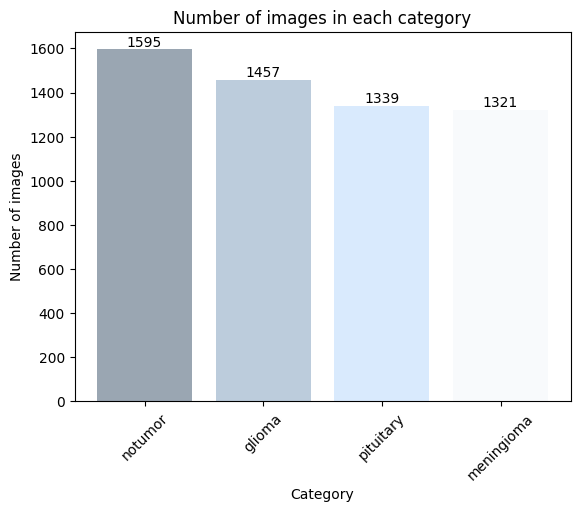

In [11]:

fig, ax = plt.subplots()
bars = ax.bar(df_train['label'].unique(), df_train['label'].value_counts(),color=color)
ax.bar_label(bars)
plt.title('Number of images in each category')
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.xticks(rotation=45)

plt.show()


In [12]:
df_train.sample(5)

,filepath,label
5574,Training/meningioma/Tr-me_0356.jpg,meningioma
4643,Training/meningioma/Tr-me_1329.jpg,meningioma
1715,Training/glioma/Tr-gl_1009.jpg,glioma
929,Training/notumor/Tr-no_1077.jpg,notumor
176,Training/notumor/Tr-no_1451.jpg,notumor


In [13]:
Test_df = 'Testing'

filepaths = []
labels = []
folds = os.listdir(Test_df)
for fold in folds:
    FoldPath = os.path.join(Test_df, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filepaths.append(filepath)
        labels.append(fold)

100%|██████████| 306/306 [00:00<00:00, 807713.67it/s]


In [14]:
print(len(filepaths))
print(len(labels))


1311
1311


In [15]:
print(np.unique(labels))

['glioma' 'meningioma' 'notumor' 'pituitary']


In [16]:
 df_test = pd.DataFrame(
    data = {
        'filepath': filepaths,
        'label': labels
    }
)

In [17]:
df_test.head()

,filepath,label
0,Testing/notumor/Te-no_0079.jpg,notumor
1,Testing/notumor/Te-no_0300.jpg,notumor
2,Testing/notumor/Te-no_0202.jpg,notumor
3,Testing/notumor/Te-no_0194.jpg,notumor
4,Testing/notumor/Te-no_0213.jpg,notumor


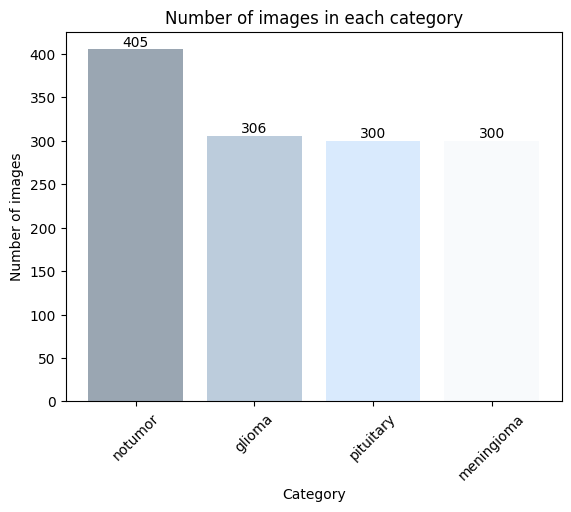

In [18]:

fig, ax = plt.subplots()
bars = ax.bar(df_test['label'].unique(), df_test['label'].value_counts(),color=color)
ax.bar_label(bars)
plt.title('Number of images in each category')
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.xticks(rotation=45)

plt.show()


# **Split data into train, test, valid**

In [19]:
valid_ts, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

In [20]:
tr_gen = ImageDataGenerator(rescale=1/255)
ts_gen = ImageDataGenerator(rescale=1/255)
batchsize = 32
img_size = (224,224)

In [21]:
gen_train = tr_gen.flow_from_dataframe(df_train, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batchsize, shuffle=True,color_mode='rgb')
gen_valid = ts_gen.flow_from_dataframe(valid_ts, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batchsize, shuffle=True,color_mode='rgb')
gen_test = ts_gen.flow_from_dataframe(df_test, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batchsize, shuffle=False ,color_mode='rgb')

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [22]:
class_dict = gen_train.class_indices


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pickle
import tensorflow as tf

# Load the model from pickle file
model_path = "/content/drive/MyDrive/ModelPretrained.pkl"
with open(model_path, 'rb') as file:
    model = pickle.load(file)

# Check the model architecture
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 344 variables whereas the saved optimizer has 686 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,268,769 (84.95 MB)

 Trainable params: 11,090,732 (42.31 MB)

 Non-trainable params: 87,303 (341.03 KB)

 Optimizer params: 11,090,734 (42.31 MB)

In [18]:
# prompt: /content/Testing/pituitary/Te-piTr_0002.jpg predict using /content/drive/MyDrive/ModelPretrained.pkl with predict no or yes

import numpy as np
from tensorflow.keras.preprocessing import image
from PIL import Image

def predict_image(image_path, model):
  img = image.load_img(image_path, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.

  prediction = model.predict(img_array)
  predicted_class = np.argmax(prediction)

  class_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

  if class_labels[predicted_class] == 'no_tumor':
      return 'no'
  else:
      return 'yes'


image_path = '/content/Testing/pituitary/Te-piTr_0002.jpg'
model_path = "/content/drive/MyDrive/ModelPretrained.pkl"
with open(model_path, 'rb') as file:
    model = pickle.load(file)

prediction = predict_image(image_path, model)
print(f"Prediction for {image_path}: {prediction}")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 344 variables whereas the saved optimizer has 686 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step
Prediction for /content/Testing/pituitary/Te-piTr_0002.jpg: yes


In [3]:
!pip install lime

In [4]:
!pip install shap


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━

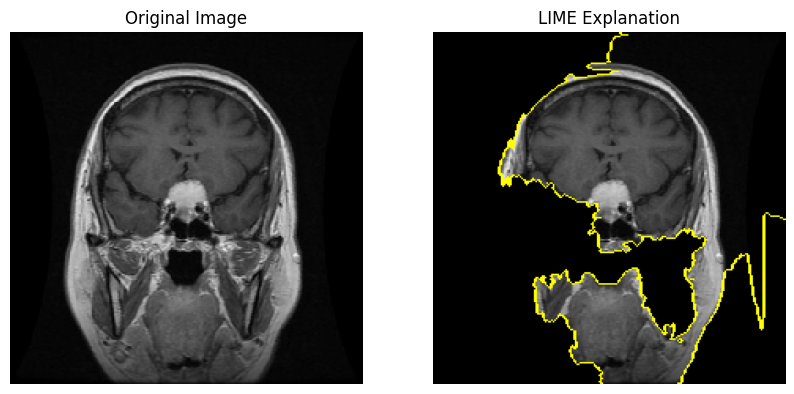

In [24]:

import tensorflow as tf
import lime
from lime import lime_image
import cv2
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Load the image
def preprocess_image(image_path, img_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize
    return img_array, img

image_path = "/content/Testing/pituitary/Te-piTr_0002.jpg"
img_array, img = preprocess_image(image_path)

# Define LIME explainer
explainer = lime_image.LimeImageExplainer()

# Define a function for LIME to call the model
def model_predict(input_img):
    return model.predict(input_img)

# Generate explanation
explanation = explainer.explain_instance(
    img_array[0], model_predict, top_labels=1, hide_color=0, num_samples=1500
)

# Get mask and overlay on the image
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True
)

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.axis("off")
plt.title("LIME Explanation")

plt.show()



In [6]:
import tensorflow as tf
import numpy as np

def preprocess_image(img_path):
    """Load and preprocess an image for the model."""
    img_size = (224, 224)

    # Load image and resize
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)

    # Convert to array and normalize
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize

    return img_array, img


In [7]:
img_array = preprocess_image("/content/Testing/glioma/Te-glTr_0000.jpg")[0]  # Ensure single image

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_7
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_7
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


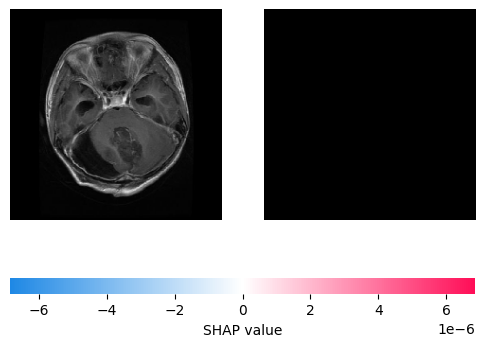

In [8]:
import shap
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess image
img_array, img = preprocess_image("/content/Testing/glioma/Te-glTr_0000.jpg")

# Create a small background dataset (random images)
background = np.random.rand(10, 224, 224, 3)

# Use GradientExplainer instead of DeepExplainer
explainer = shap.GradientExplainer(model, background)

# Compute SHAP values
shap_values = explainer.shap_values(img_array)

# Visualize SHAP explanation
shap.image_plot(shap_values, img_array)
